In [ ]:
# 导入必要的库
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from timm.layers import trunc_normal_, DropPath
from torchvision.datasets import CIFAR100
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm  


def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


set_seed(42)


save_dir = './pretrained_checkpoints'
os.makedirs(save_dir, exist_ok=True)


curve_path = os.path.join(save_dir, 'using_pre_training_curves.png')

In [ ]:
class LayerNorm(nn.Module):
    """LayerNorm"""
    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError 
        self.normalized_shape = (normalized_shape, )
    
    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x

class Block(nn.Module):
    """ConvNeXt Block"""
    def __init__(self, dim, drop_path=0., layer_scale_init_value=1e-6):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim) 
        self.norm = LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim) 
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.gamma = nn.Parameter(layer_scale_init_value * torch.ones((dim)), 
                                    requires_grad=True) if layer_scale_init_value > 0 else None
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1) 
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        if self.gamma is not None:
            x = self.gamma * x
        x = x.permute(0, 3, 1, 2) 

        x = input + self.drop_path(x)
        return x

In [ ]:
class ConvNeXt(nn.Module):
    
    def __init__(self, in_chans=3, num_classes=100, 
                 depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], drop_path_rate=0.1, 
                 layer_scale_init_value=1e-6, head_init_scale=1.):
        super().__init__()

        # 下采样层
        self.downsample_layers = nn.ModuleList()
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4),
            LayerNorm(dims[0], eps=1e-6, data_format="channels_first")
        )
        self.downsample_layers.append(stem)
        for i in range(3):
            downsample_layer = nn.Sequential(
                LayerNorm(dims[i], eps=1e-6, data_format="channels_first"),
                nn.Conv2d(dims[i], dims[i+1], kernel_size=2, stride=2),
            )
            self.downsample_layers.append(downsample_layer)

        # 主干网络
        self.stages = nn.ModuleList()
        dp_rates=[x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))] 
        cur = 0
        for i in range(4):
            stage = nn.Sequential(
                *[Block(dim=dims[i], drop_path=dp_rates[cur + j], 
                layer_scale_init_value=layer_scale_init_value) for j in range(depths[i])]
            )
            self.stages.append(stage)
            cur += depths[i]

        # 分类头
        self.norm = nn.LayerNorm(dims[-1], eps=1e-6)
        self.head = nn.Linear(dims[-1], num_classes)

        # 权重初始化
        self.apply(self._init_weights)
        self.head.weight.data.mul_(head_init_scale)
        self.head.bias.data.mul_(head_init_scale)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            trunc_normal_(m.weight, std=.02)
            nn.init.constant_(m.bias, 0)

    def forward_features(self, x):
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
        return self.norm(x.mean([-2, -1])) 

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

In [ ]:
# 预训练模型URL
model_urls = {
    "convnext_tiny_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_1k_224_ema.pth",
    "convnext_small_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_small_1k_224_ema.pth",
    "convnext_base_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_base_1k_224_ema.pth",
    "convnext_large_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_large_1k_224_ema.pth",
}

def convnext_tiny_cifar100(pretrained=True):
   
    model = ConvNeXt(depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], num_classes=100)
    
    if pretrained:
        # 加载预训练权重
        url = model_urls['convnext_tiny_1k']
        checkpoint = torch.hub.load_state_dict_from_url(url=url, map_location="cpu", check_hash=True)
        
       
        if 'model' in checkpoint:
            checkpoint = checkpoint['model']
        if 'head.weight' in checkpoint:
            checkpoint.pop('head.weight')
        if 'head.bias' in checkpoint:
            checkpoint.pop('head.bias')
        

        model.load_state_dict(checkpoint, strict=False)
        print("预训练权重加载完成！")
    
    return model

In [ ]:
def get_cifar100_loaders(batch_size=64, num_workers=2):

    # 简单的数据转换
    transform = transforms.Compose([
        transforms.Resize(224),  # ConvNeXt期望224x224输入
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
    ])
    
    # 加载CIFAR100数据集
    train_dataset = CIFAR100(root='./data', train=True, download=True, transform=transform)
    valid_dataset = CIFAR100(root='./data', train=False, download=True, transform=transform)
    
    # 创建数据加载器
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True
    )
    
    valid_loader = DataLoader(
        valid_dataset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True
    )
    
    return train_loader, valid_loader

# 获取数据加载器
train_loader, valid_loader = get_cifar100_loaders(batch_size=64)
print(f"数据集大小 - 训练集: {len(train_loader.dataset)}, 验证集: {len(valid_loader.dataset)}")

数据集大小 - 训练集: 50000, 验证集: 10000


In [7]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    """训练一个epoch"""
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc='训练中')
    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        pbar.set_postfix({
            'loss': train_loss/(batch_idx+1),
            'acc': 100.*correct/total
        })
    
    return train_loss/len(train_loader), 100.*correct/total

def validate(model, valid_loader, criterion, device):
    """验证函数"""
    model.eval()
    valid_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(valid_loader, desc='验证中')
        for batch_idx, (inputs, targets) in enumerate(pbar):
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            valid_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            pbar.set_postfix({
                'loss': valid_loss/(batch_idx+1),
                'acc': 100.*correct/total
            })
    
    return valid_loss/len(valid_loader), 100.*correct/total

def plot_training_curves(train_losses, valid_losses, train_accs, valid_accs, save_path=curve_path):
    """绘制训练曲线并保存"""
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='train_loss')
    plt.plot(valid_losses, label='test_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss_curve')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='train_accuracy')
    plt.plot(valid_accs, label='test_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy(%)')
    plt.legend()
    plt.title('Accuracy_curve')
    
    plt.tight_layout()
    
    # 保存图像
    plt.savefig(save_path)
    
    # 在Jupyter中显示图像
    plt.show()

In [ ]:
# 设置训练参数
lr = 1e-5                 # 学习率
batch_size = 64           # 批次大小  
num_epochs = 30           # 训练轮次
weight_decay = 1e-4       # 权重衰减
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"使用设备: {device}")


model = convnext_tiny_cifar100(pretrained=True)
model = model.to(device)
print(model)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"总参数量: {total_params:,}")
print(f"可训练参数量: {trainable_params:,}")



criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

使用设备: cuda
预训练权重加载完成！
ConvNeXt(
  (downsample_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm()
    )
    (1): Sequential(
      (0): LayerNorm()
      (1): Conv2d(96, 192, kernel_size=(2, 2), stride=(2, 2))
    )
    (2): Sequential(
      (0): LayerNorm()
      (1): Conv2d(192, 384, kernel_size=(2, 2), stride=(2, 2))
    )
    (3): Sequential(
      (0): LayerNorm()
      (1): Conv2d(384, 768, kernel_size=(2, 2), stride=(2, 2))
    )
  )
  (stages): ModuleList(
    (0): Sequential(
      (0): Block(
        (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
        (norm): LayerNorm()
        (pwconv1): Linear(in_features=96, out_features=384, bias=True)
        (act): GELU(approximate='none')
        (pwconv2): Linear(in_features=384, out_features=96, bias=True)
        (drop_path): Identity()
      )
      (1): Block(
        (dwconv): Conv2d(96, 96, kernel_size=(7, 7), st

开始预训练模型微调，总共30轮...

轮次: 1/30


训练中:   0%|          | 0/782 [00:00<?, ?it/s]

验证中:   0%|          | 0/157 [00:00<?, ?it/s]

保存最佳模型，准确率: 46.95%


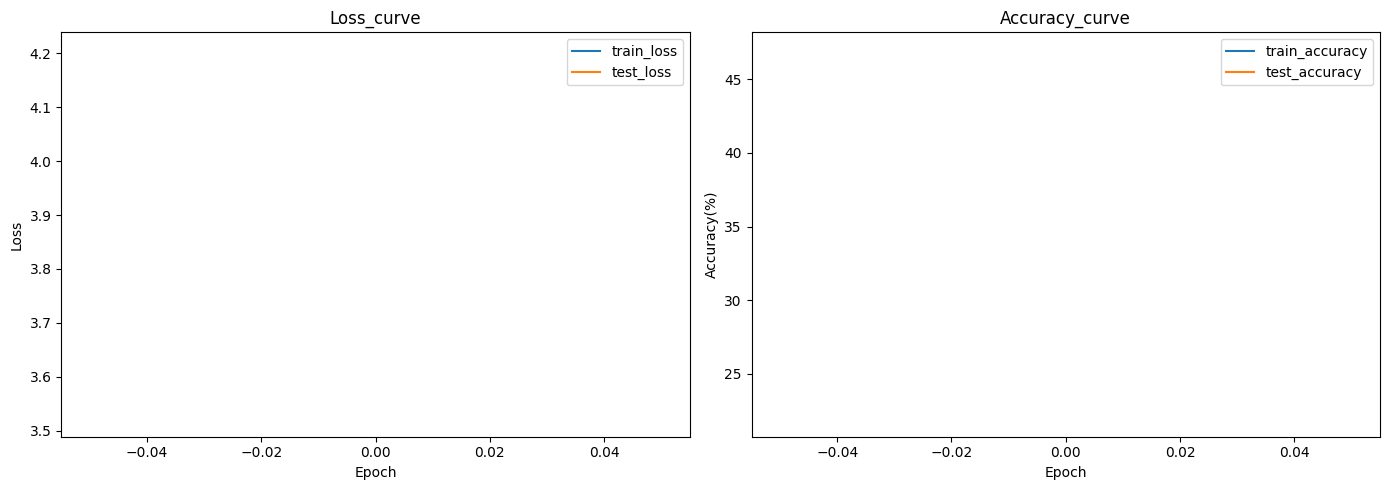


轮次: 2/30


训练中:   0%|          | 0/782 [00:00<?, ?it/s]

验证中:   0%|          | 0/157 [00:00<?, ?it/s]

保存最佳模型，准确率: 60.88%


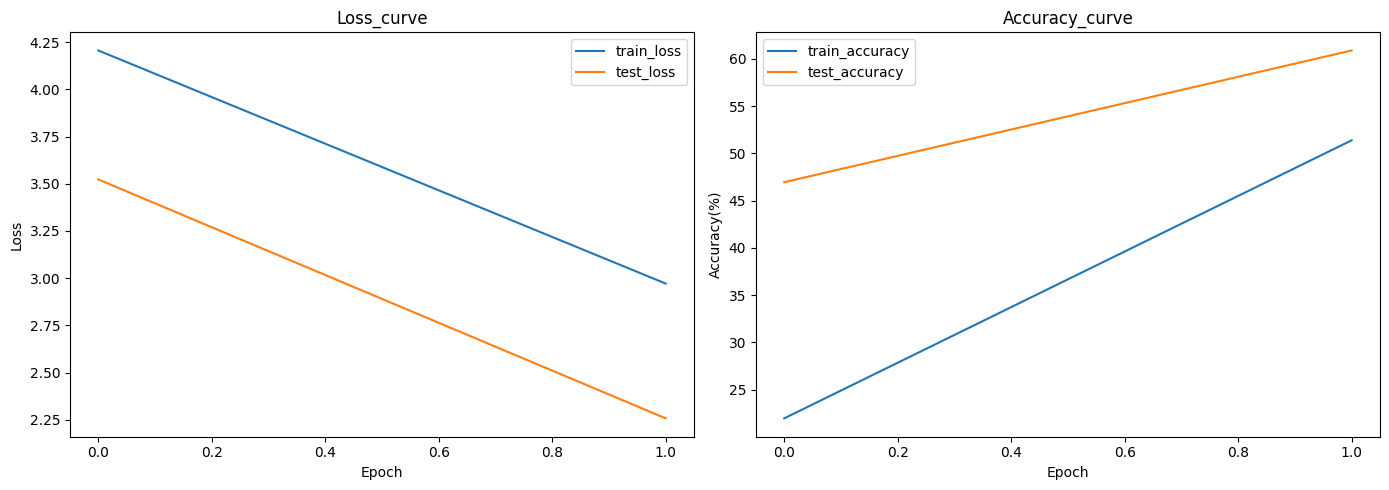


轮次: 3/30


训练中:   0%|          | 0/782 [00:00<?, ?it/s]

验证中:   0%|          | 0/157 [00:00<?, ?it/s]

保存最佳模型，准确率: 69.29%


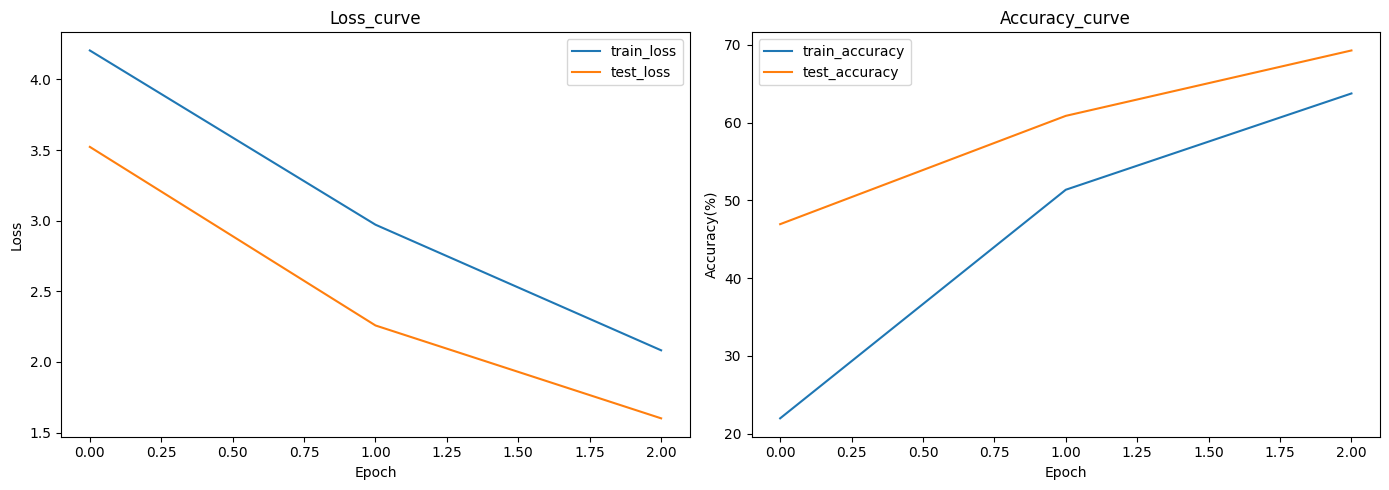


轮次: 4/30


训练中:   0%|          | 0/782 [00:00<?, ?it/s]

验证中:   0%|          | 0/157 [00:00<?, ?it/s]

保存最佳模型，准确率: 74.55%


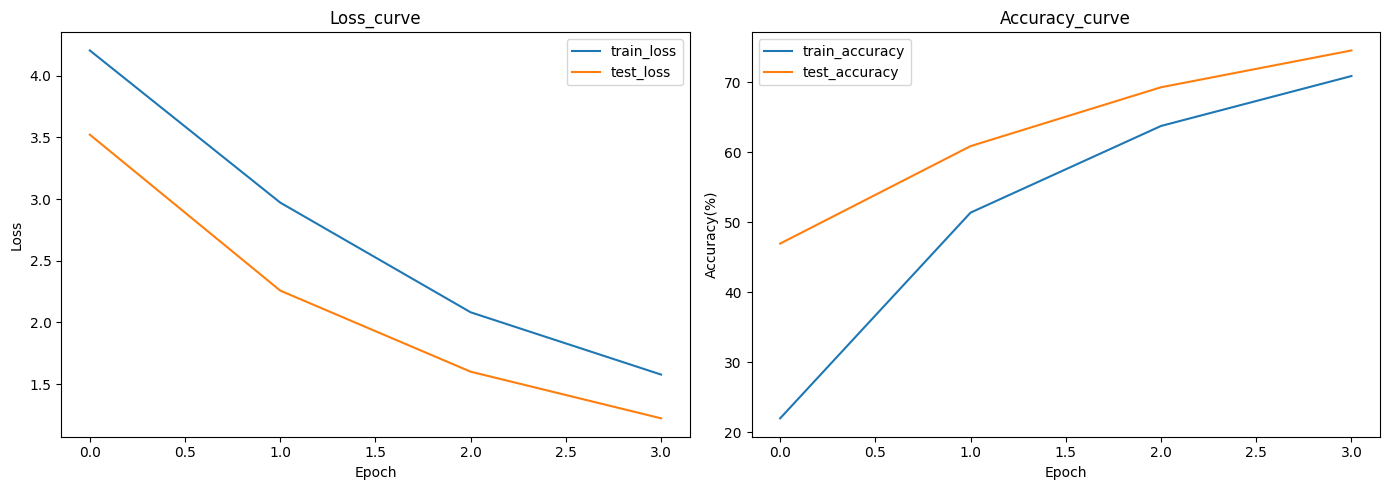


轮次: 5/30


训练中:   0%|          | 0/782 [00:00<?, ?it/s]

验证中:   0%|          | 0/157 [00:00<?, ?it/s]

保存最佳模型，准确率: 77.70%


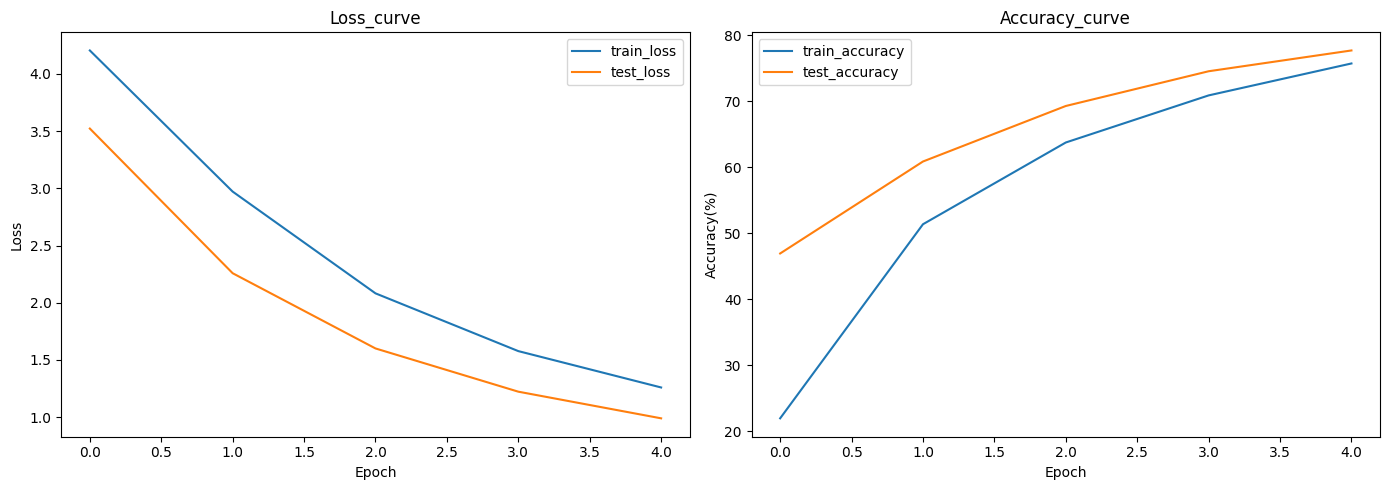


轮次: 6/30


训练中:   0%|          | 0/782 [00:00<?, ?it/s]

验证中:   0%|          | 0/157 [00:00<?, ?it/s]

保存最佳模型，准确率: 80.02%


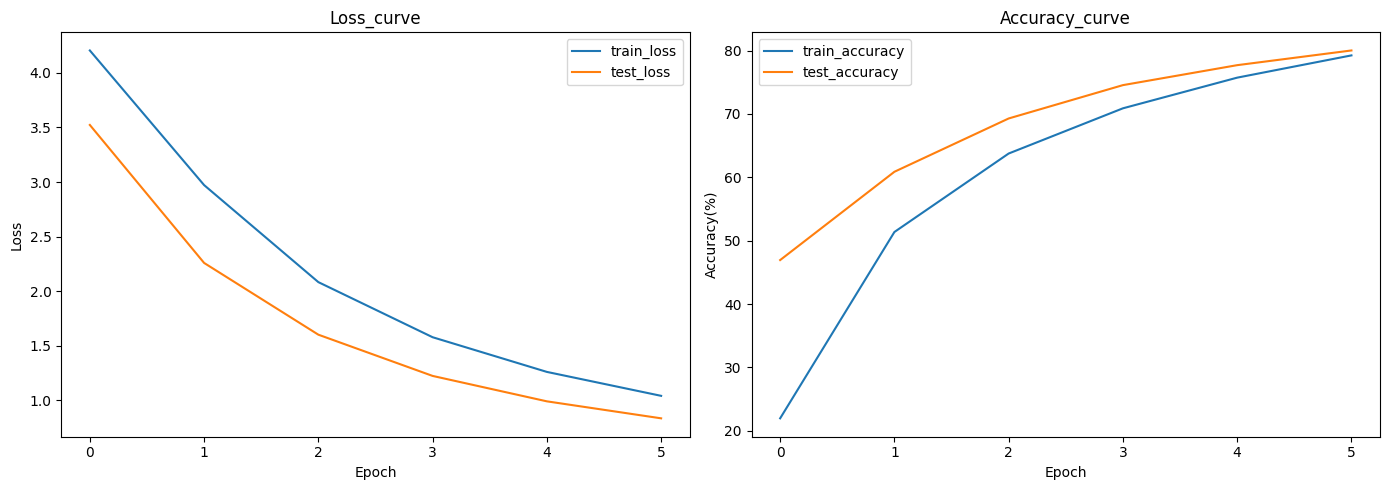


轮次: 7/30


训练中:   0%|          | 0/782 [00:00<?, ?it/s]

验证中:   0%|          | 0/157 [00:00<?, ?it/s]

保存最佳模型，准确率: 81.43%


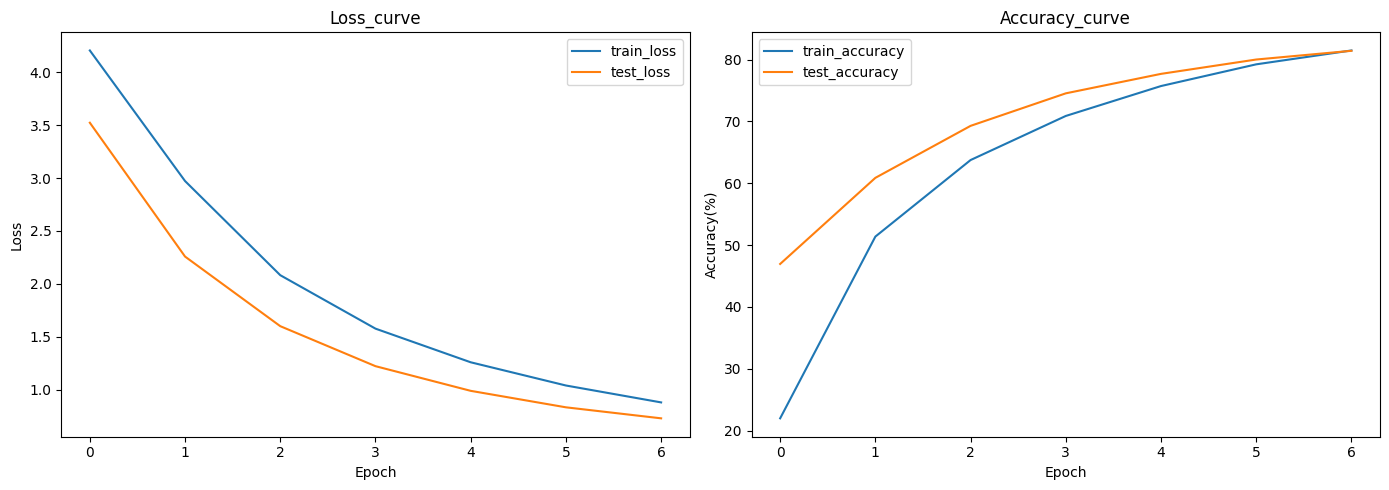


轮次: 8/30


训练中:   0%|          | 0/782 [00:00<?, ?it/s]

验证中:   0%|          | 0/157 [00:00<?, ?it/s]

保存最佳模型，准确率: 82.55%


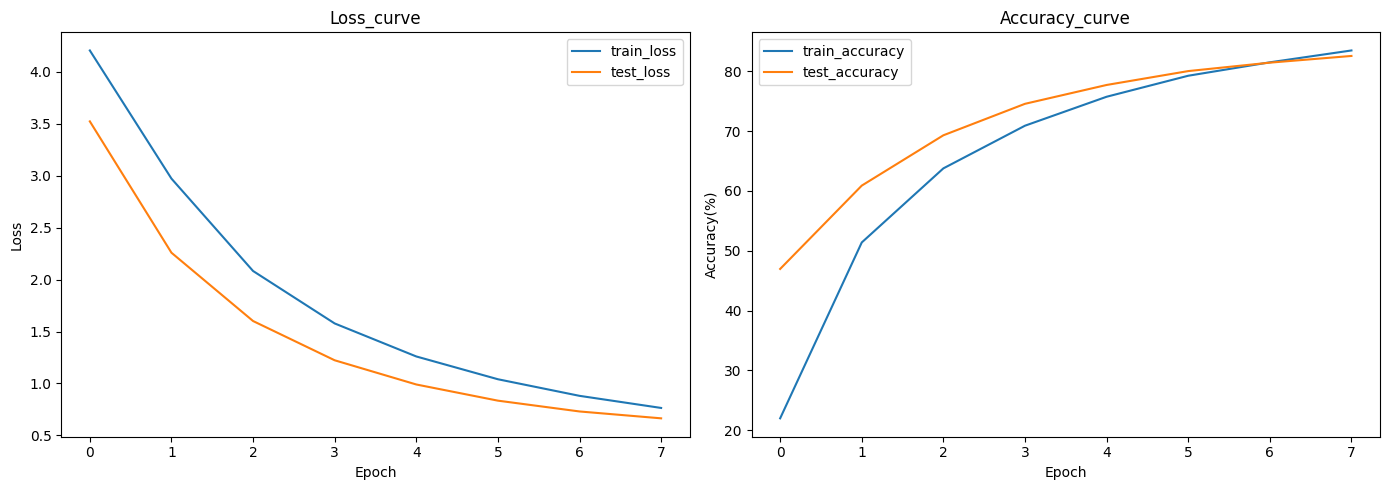


轮次: 9/30


训练中:   0%|          | 0/782 [00:00<?, ?it/s]

验证中:   0%|          | 0/157 [00:00<?, ?it/s]

保存最佳模型，准确率: 83.17%


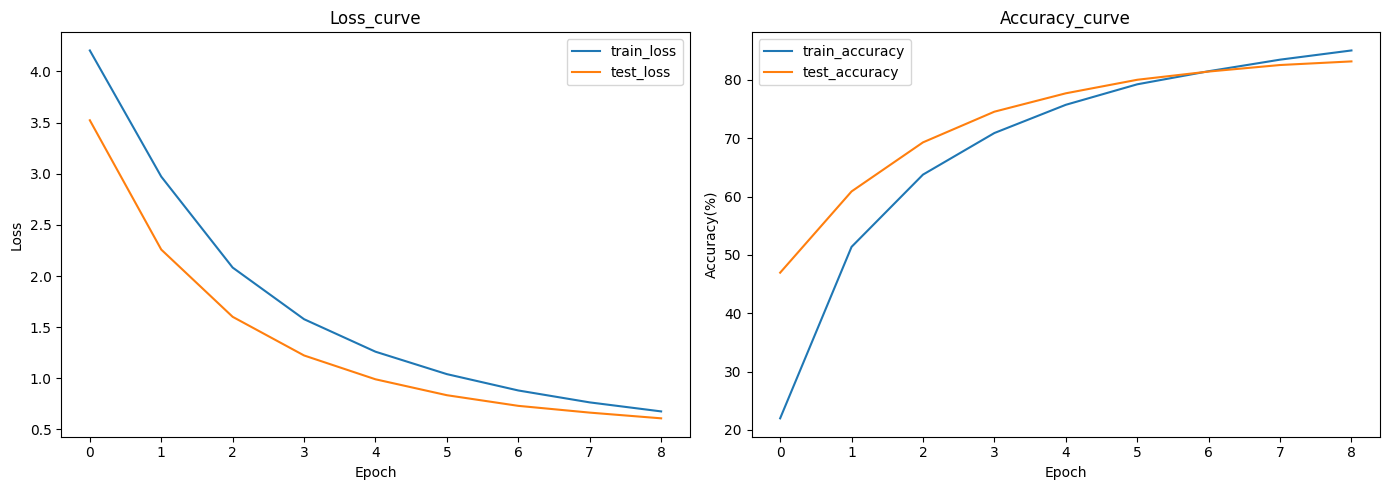


轮次: 10/30


训练中:   0%|          | 0/782 [00:00<?, ?it/s]

验证中:   0%|          | 0/157 [00:00<?, ?it/s]

保存最佳模型，准确率: 83.89%


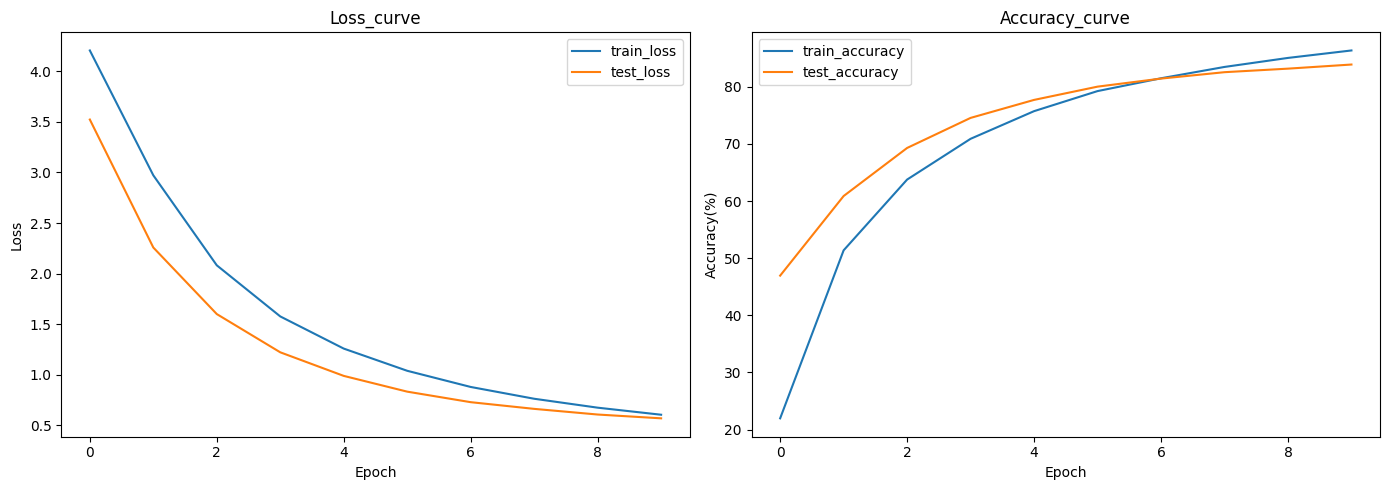


轮次: 11/30


训练中:   0%|          | 0/782 [00:00<?, ?it/s]

验证中:   0%|          | 0/157 [00:00<?, ?it/s]

保存最佳模型，准确率: 84.36%


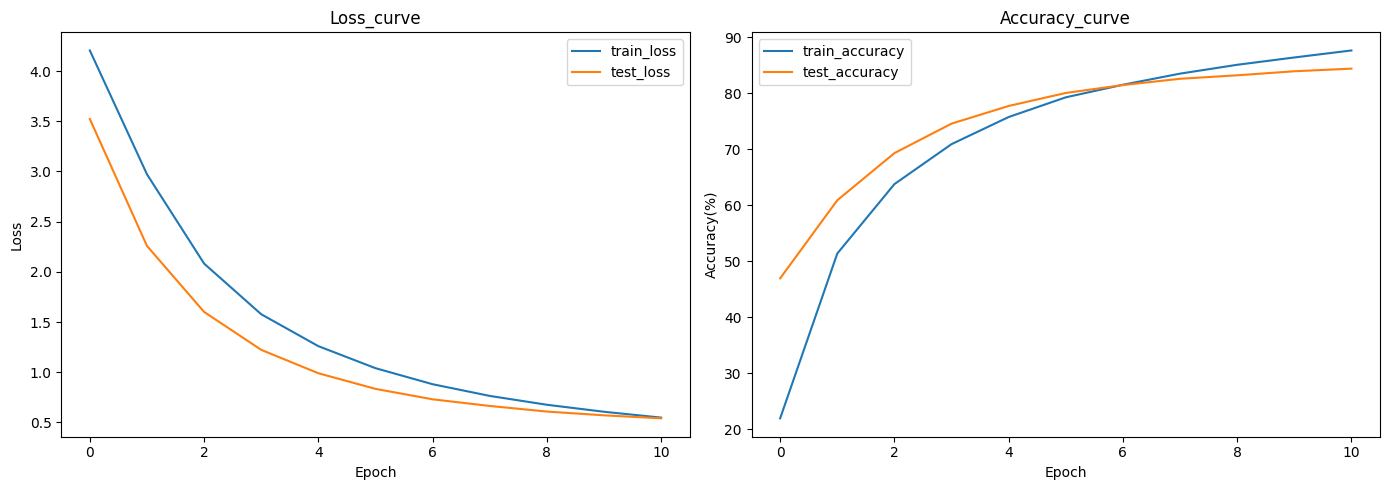


轮次: 12/30


训练中:   0%|          | 0/782 [00:00<?, ?it/s]

验证中:   0%|          | 0/157 [00:00<?, ?it/s]

保存最佳模型，准确率: 84.82%


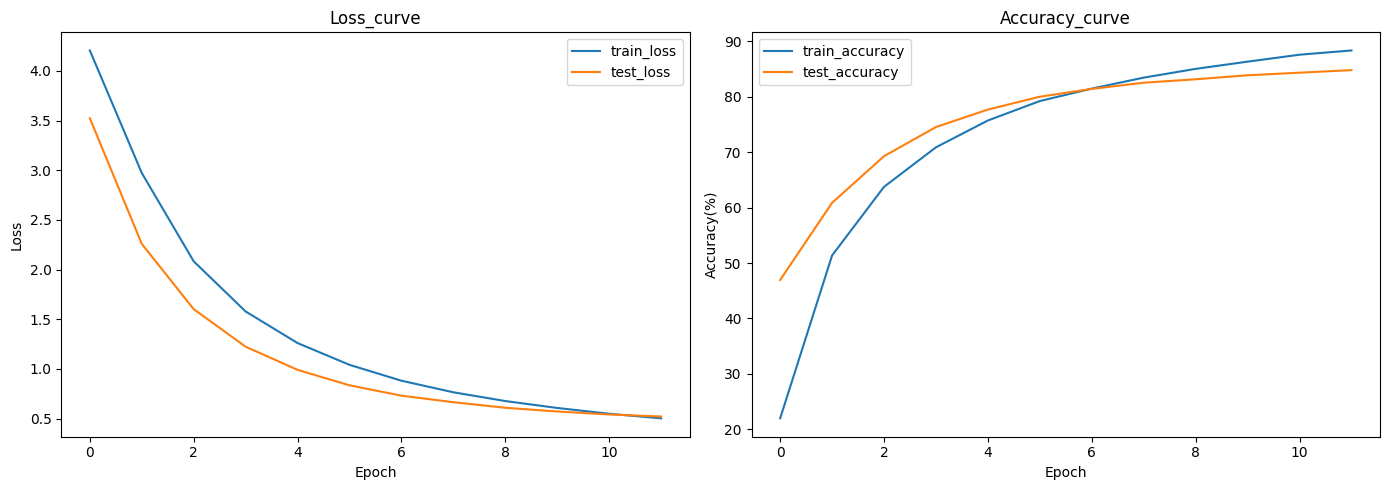


轮次: 13/30


训练中:   0%|          | 0/782 [00:00<?, ?it/s]

验证中:   0%|          | 0/157 [00:00<?, ?it/s]

保存最佳模型，准确率: 85.13%


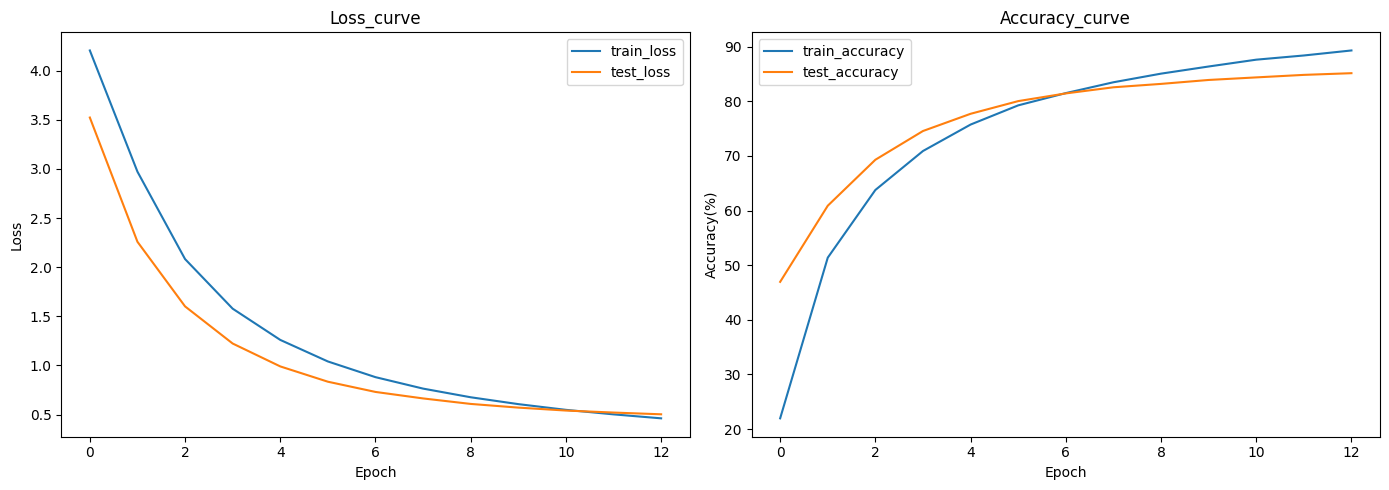


轮次: 14/30


训练中:   0%|          | 0/782 [00:00<?, ?it/s]

验证中:   0%|          | 0/157 [00:00<?, ?it/s]

保存最佳模型，准确率: 85.45%


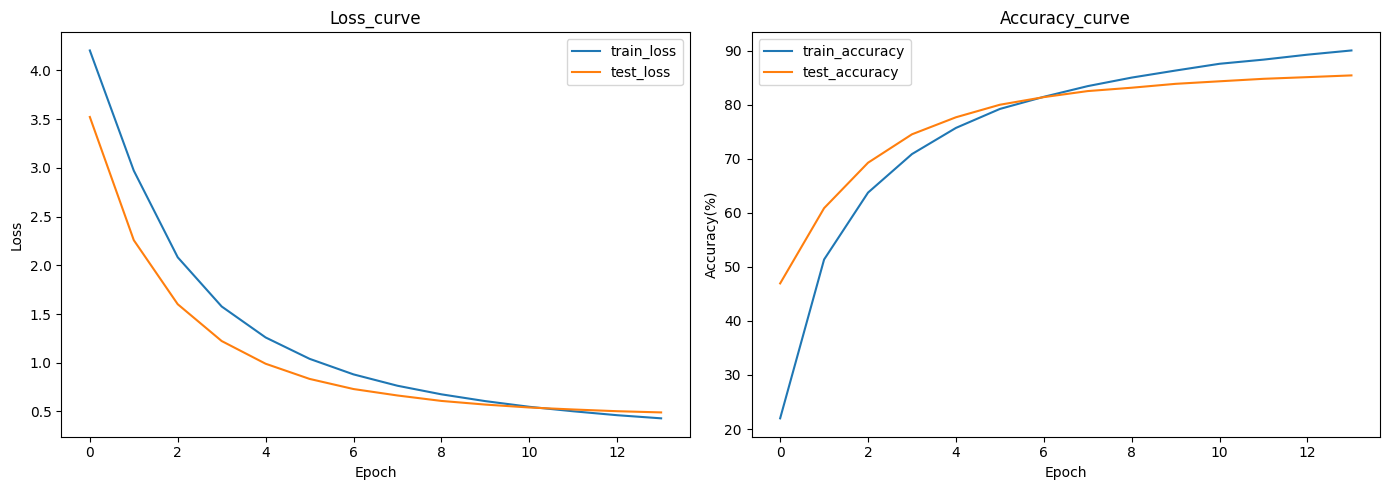


轮次: 15/30


训练中:   0%|          | 0/782 [00:00<?, ?it/s]

验证中:   0%|          | 0/157 [00:00<?, ?it/s]

保存最佳模型，准确率: 85.70%


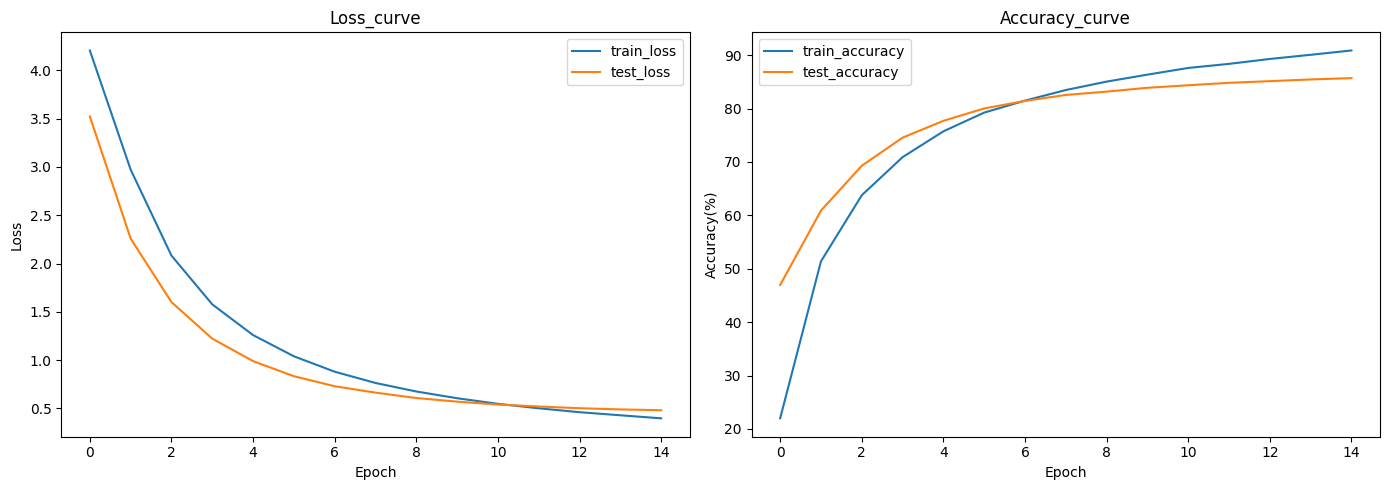


轮次: 16/30


训练中:   0%|          | 0/782 [00:00<?, ?it/s]

验证中:   0%|          | 0/157 [00:00<?, ?it/s]

保存最佳模型，准确率: 85.77%


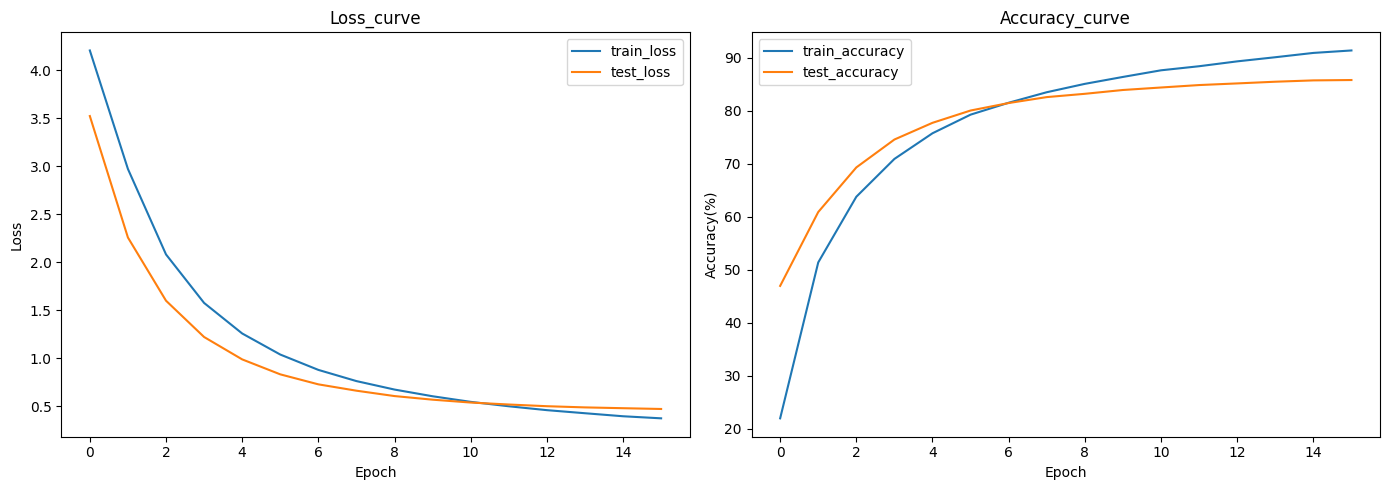


轮次: 17/30


训练中:   0%|          | 0/782 [00:00<?, ?it/s]

验证中:   0%|          | 0/157 [00:00<?, ?it/s]

保存最佳模型，准确率: 85.97%


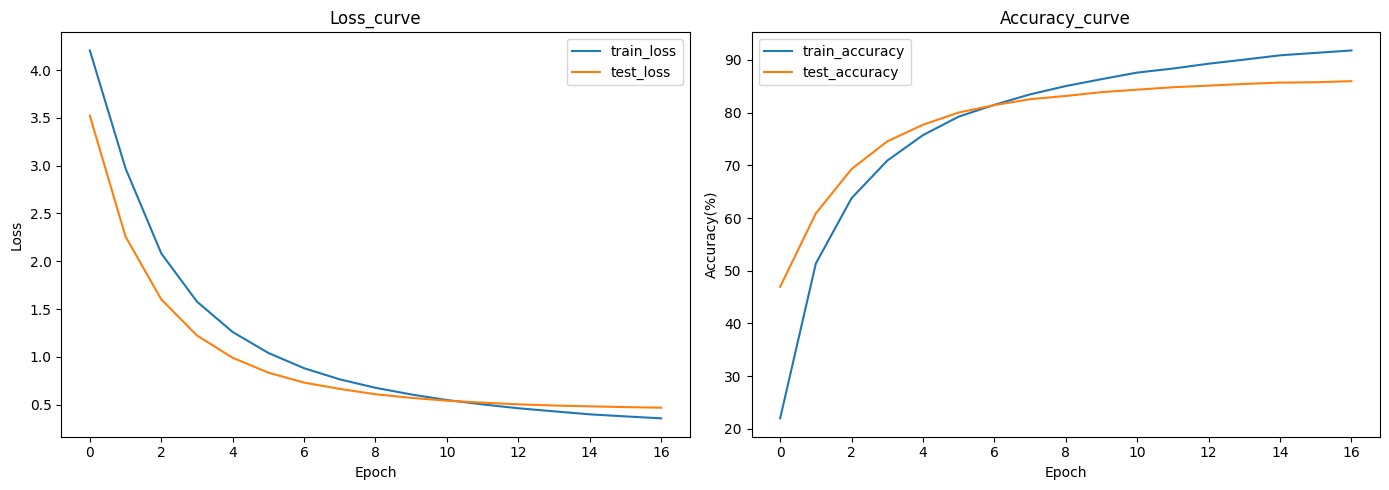


轮次: 18/30


训练中:   0%|          | 0/782 [00:00<?, ?it/s]

验证中:   0%|          | 0/157 [00:00<?, ?it/s]

保存最佳模型，准确率: 86.17%


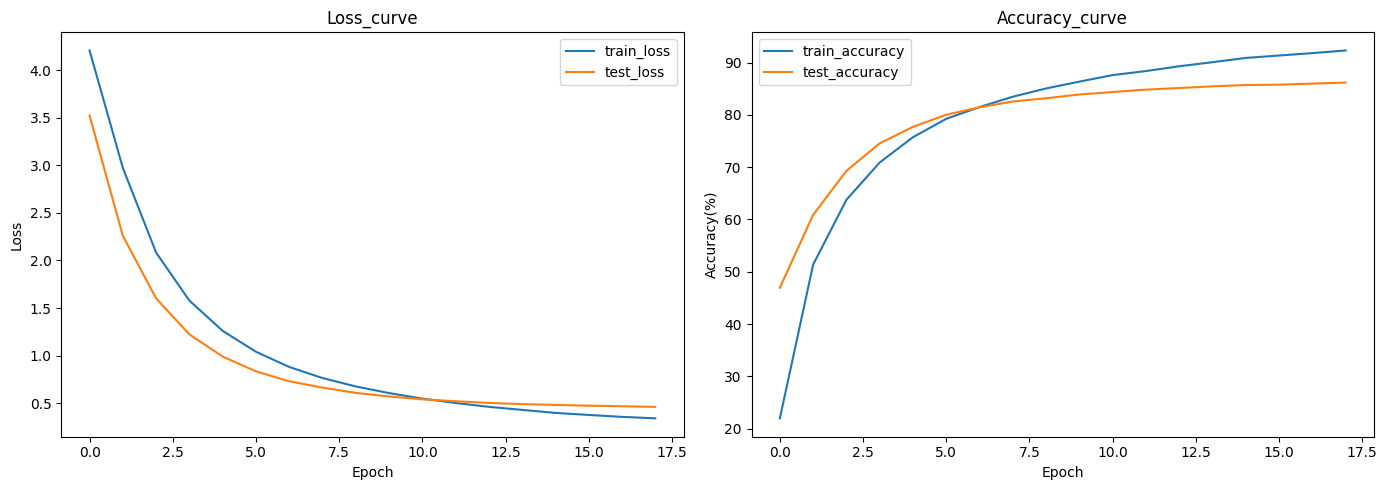


轮次: 19/30


训练中:   0%|          | 0/782 [00:00<?, ?it/s]

验证中:   0%|          | 0/157 [00:00<?, ?it/s]

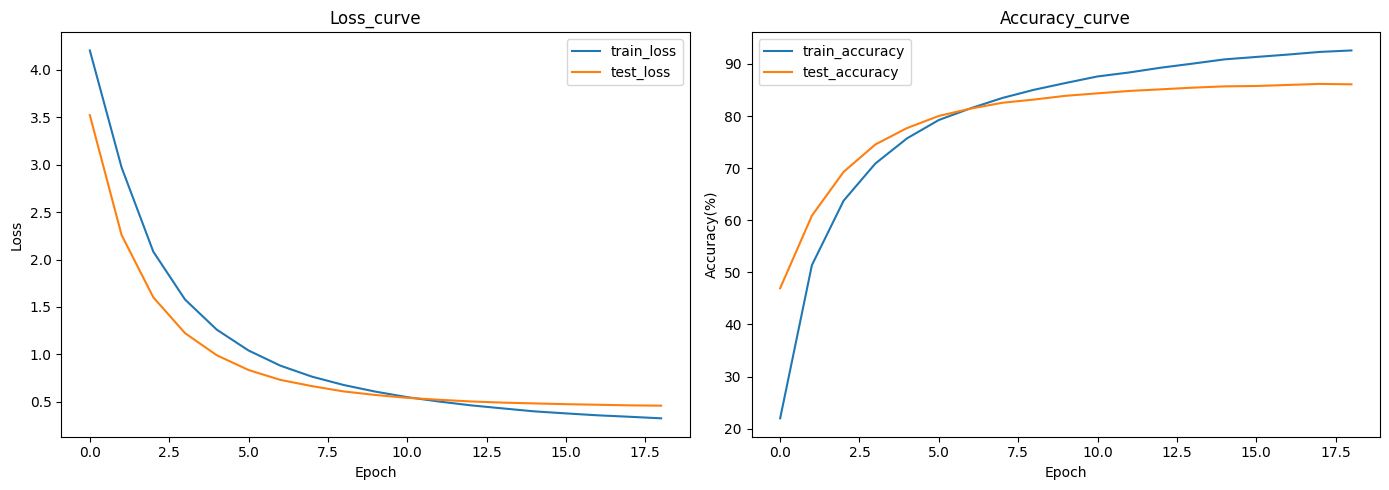


轮次: 20/30


训练中:   0%|          | 0/782 [00:00<?, ?it/s]

验证中:   0%|          | 0/157 [00:00<?, ?it/s]

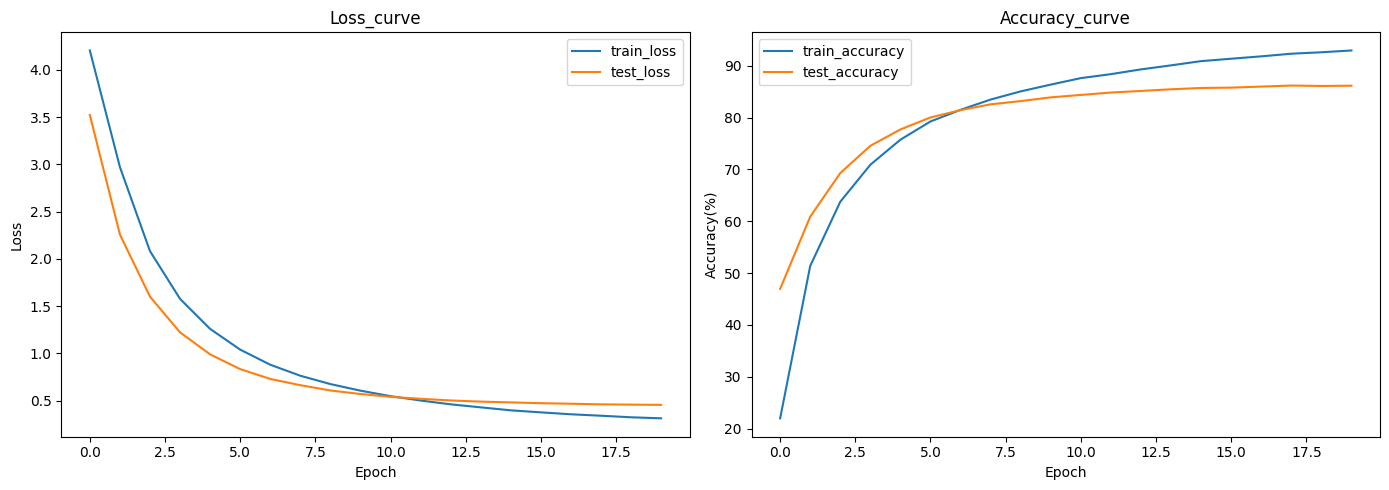


轮次: 21/30


训练中:   0%|          | 0/782 [00:00<?, ?it/s]

验证中:   0%|          | 0/157 [00:00<?, ?it/s]

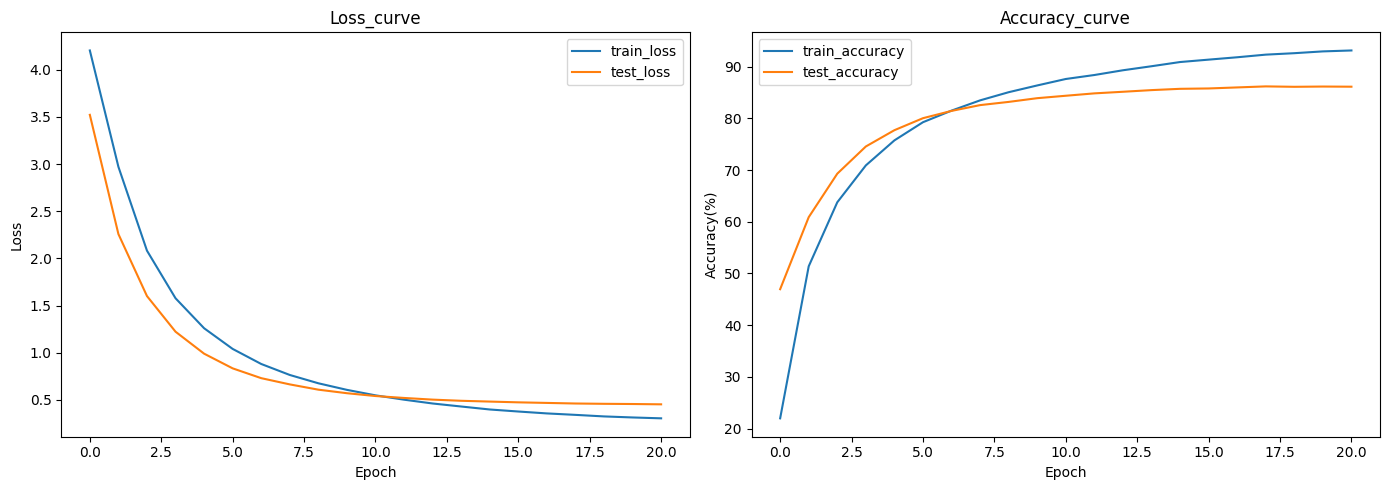


轮次: 22/30


训练中:   0%|          | 0/782 [00:00<?, ?it/s]

验证中:   0%|          | 0/157 [00:00<?, ?it/s]

保存最佳模型，准确率: 86.28%


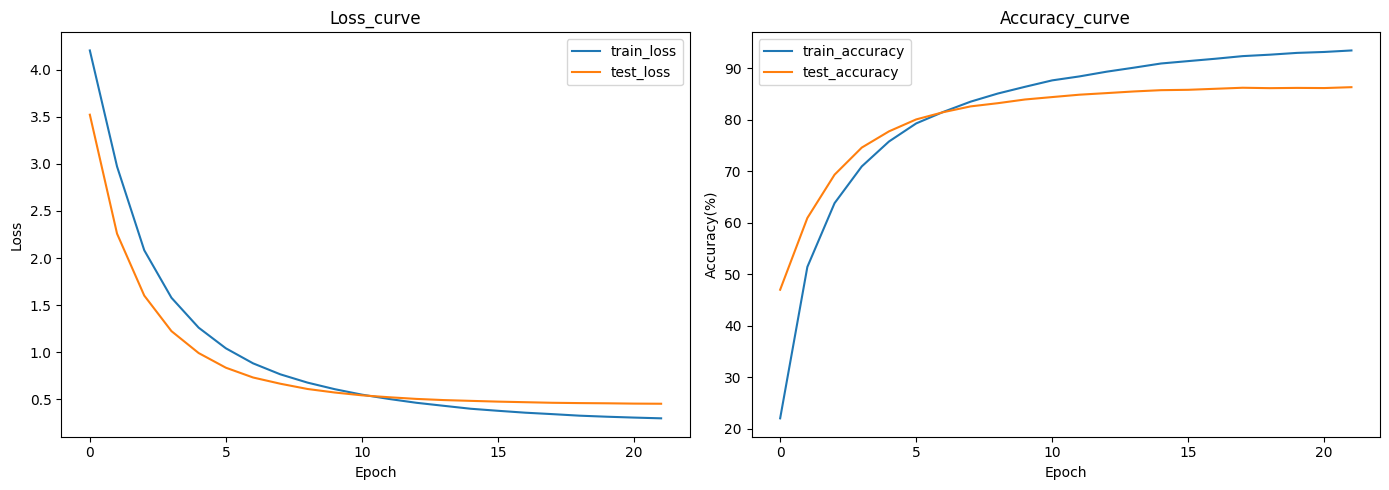


轮次: 23/30


训练中:   0%|          | 0/782 [00:00<?, ?it/s]

验证中:   0%|          | 0/157 [00:00<?, ?it/s]

保存最佳模型，准确率: 86.34%


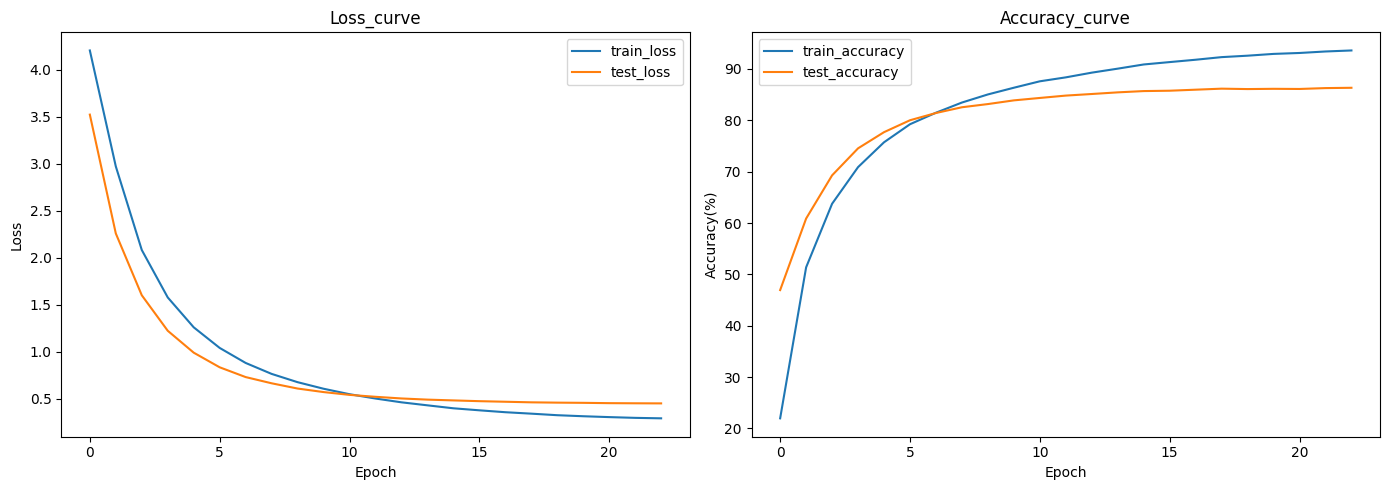


轮次: 24/30


训练中:   0%|          | 0/782 [00:00<?, ?it/s]

验证中:   0%|          | 0/157 [00:00<?, ?it/s]

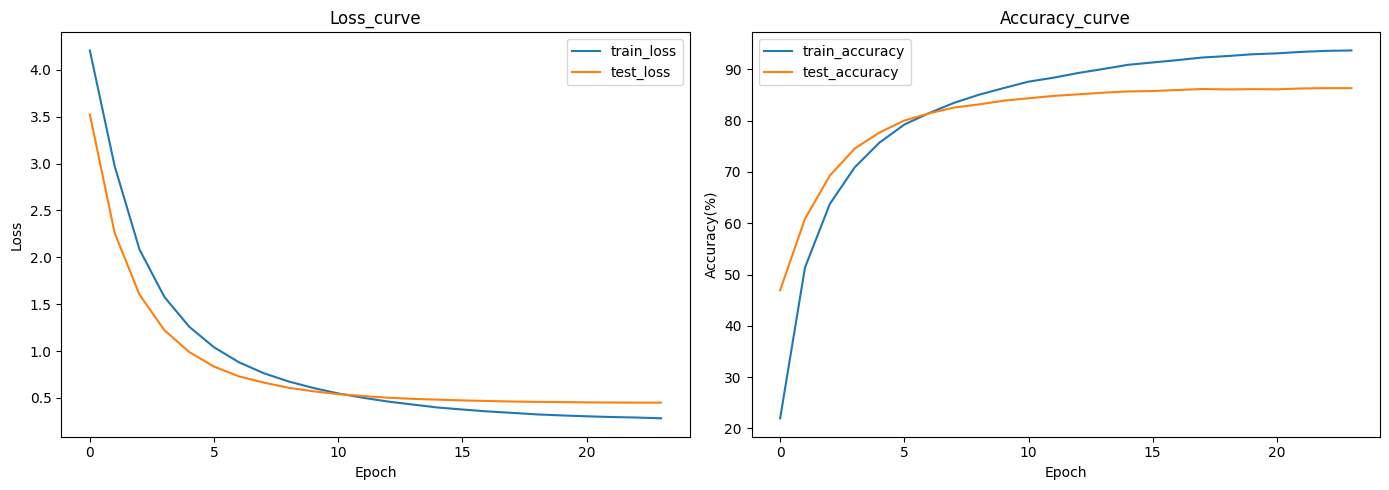


轮次: 25/30


训练中:   0%|          | 0/782 [00:00<?, ?it/s]

验证中:   0%|          | 0/157 [00:00<?, ?it/s]

保存最佳模型，准确率: 86.43%


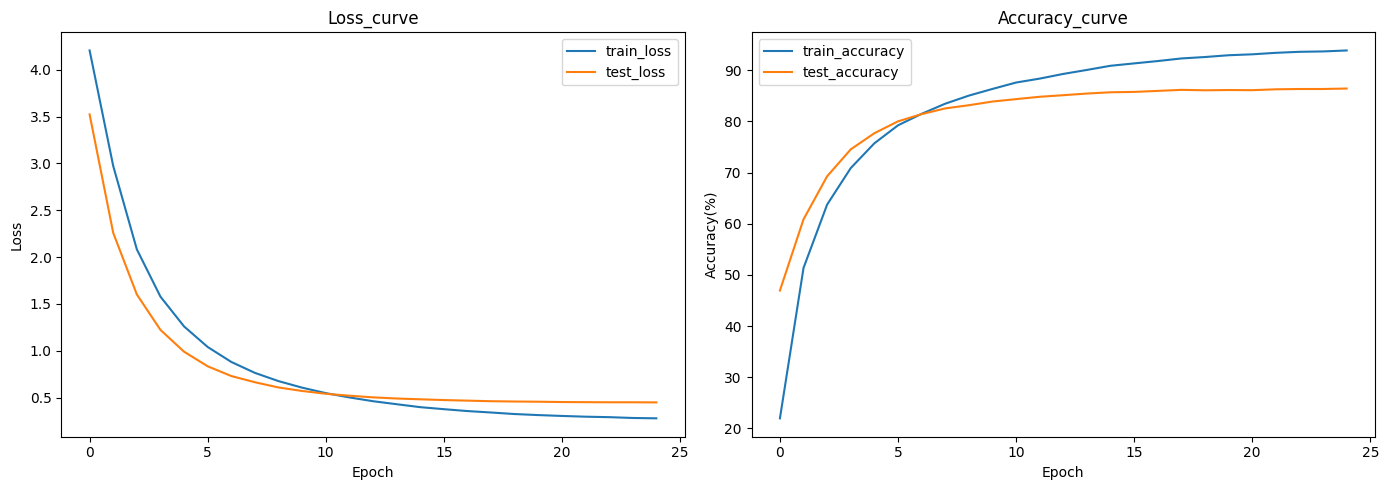


轮次: 26/30


训练中:   0%|          | 0/782 [00:00<?, ?it/s]

验证中:   0%|          | 0/157 [00:00<?, ?it/s]

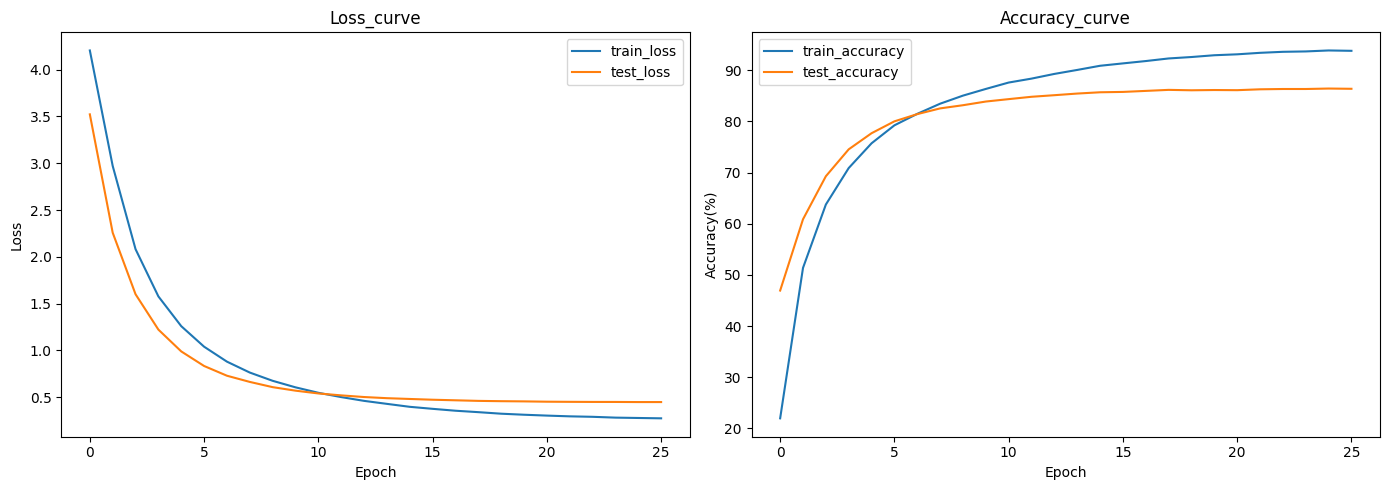


轮次: 27/30


训练中:   0%|          | 0/782 [00:00<?, ?it/s]

验证中:   0%|          | 0/157 [00:00<?, ?it/s]

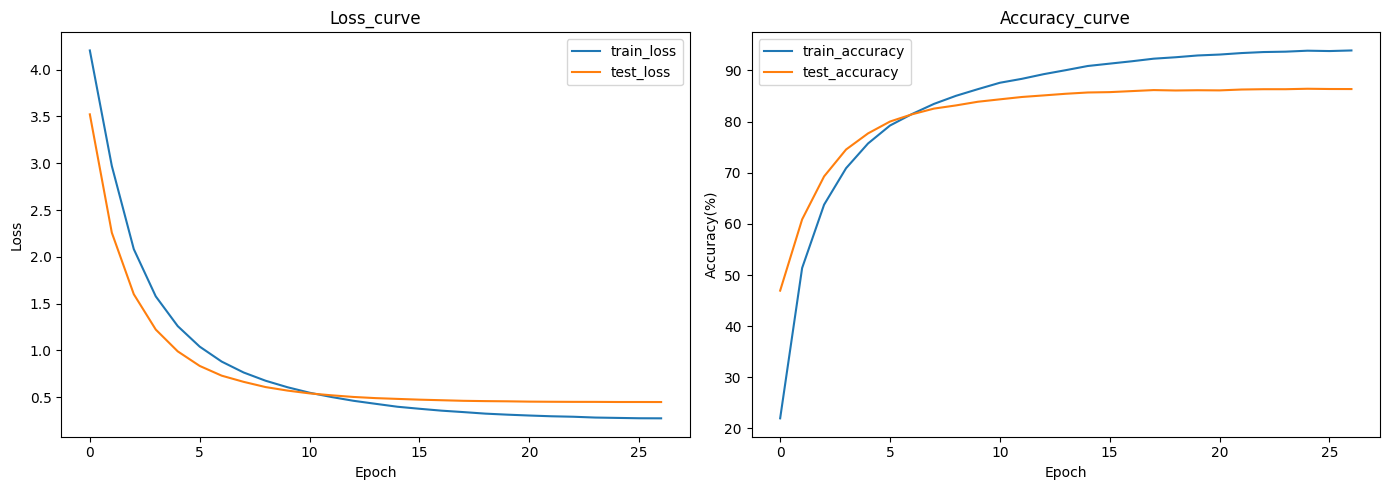


轮次: 28/30


训练中:   0%|          | 0/782 [00:00<?, ?it/s]

验证中:   0%|          | 0/157 [00:00<?, ?it/s]

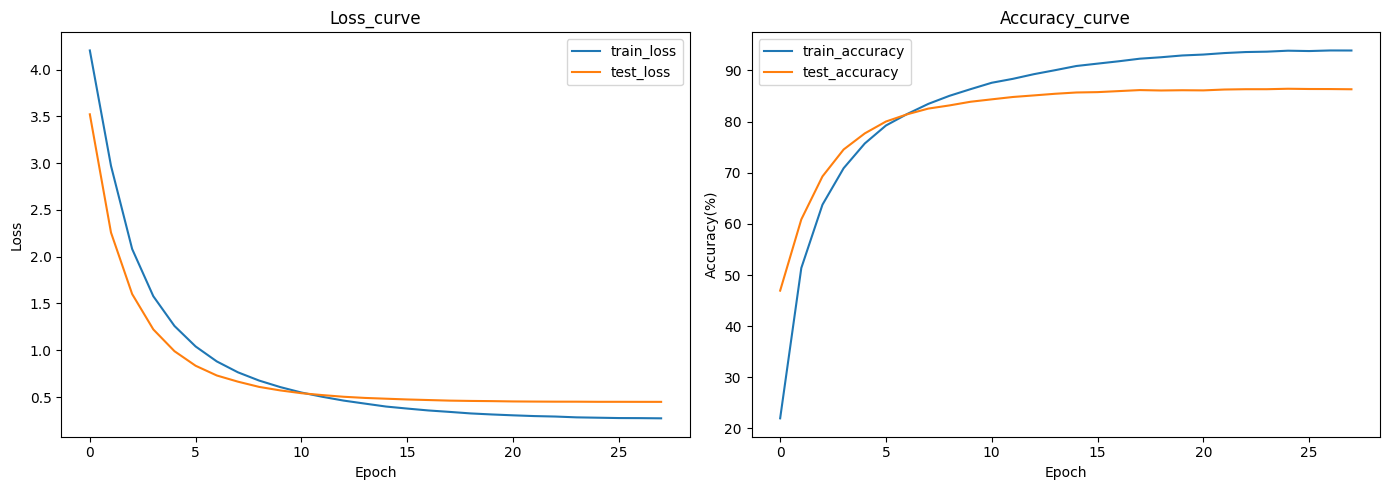


轮次: 29/30


训练中:   0%|          | 0/782 [00:00<?, ?it/s]

验证中:   0%|          | 0/157 [00:00<?, ?it/s]

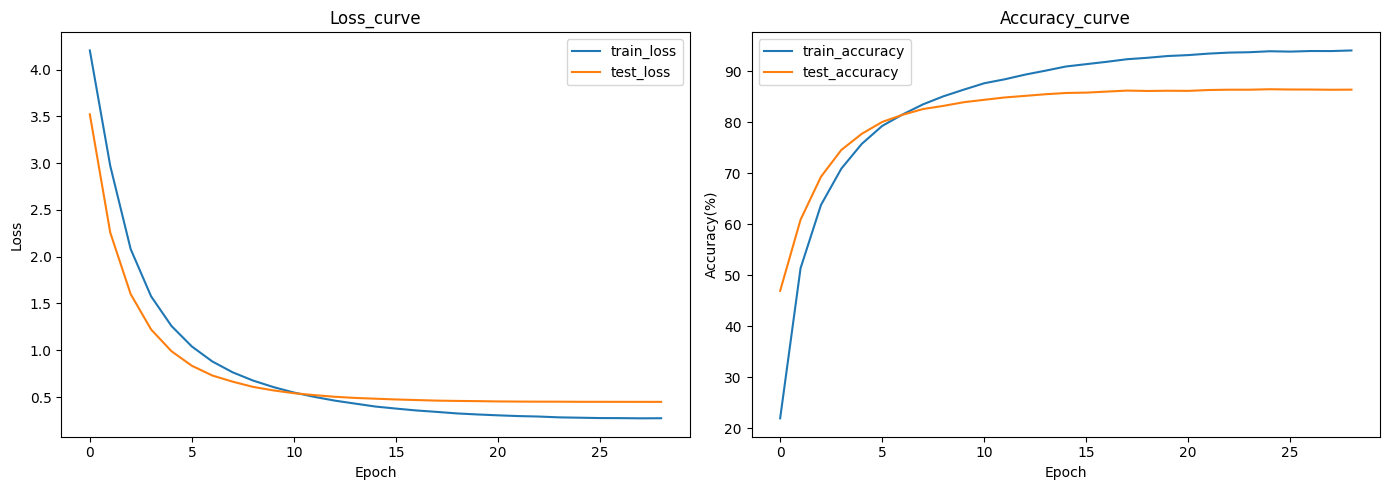


轮次: 30/30


训练中:   0%|          | 0/782 [00:00<?, ?it/s]

验证中:   0%|          | 0/157 [00:00<?, ?it/s]

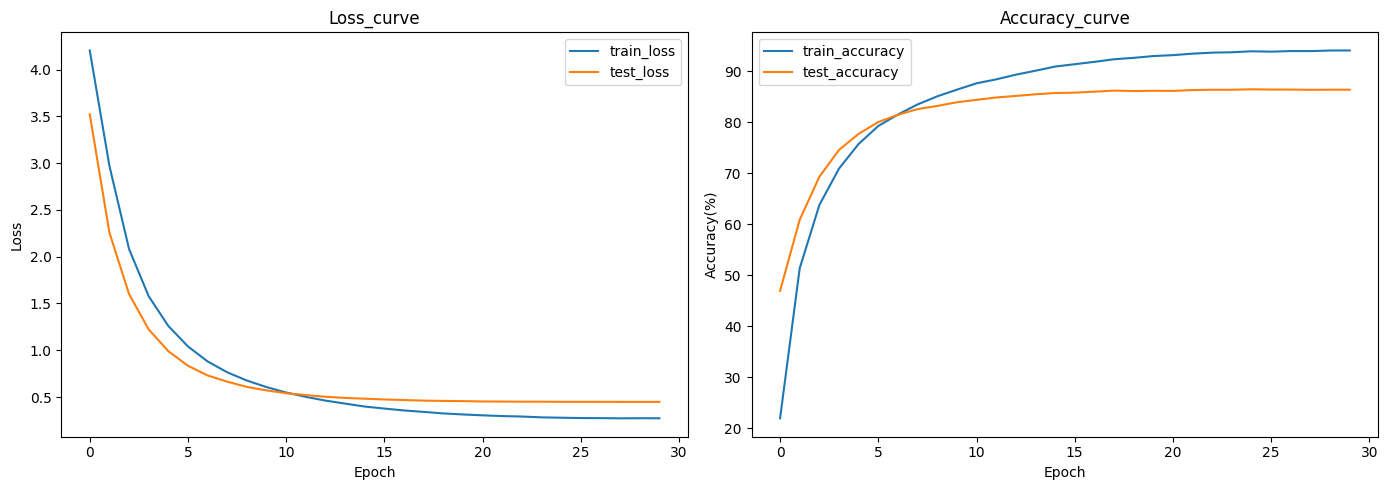

训练完成! 最佳验证准确率: 86.43%


In [11]:
# 训练循环
train_losses, valid_losses = [], []
train_accs, valid_accs = [], []
best_acc = 0

print(f"开始预训练模型微调，总共{num_epochs}轮...")

for epoch in range(num_epochs):
    print(f"\n轮次: {epoch+1}/{num_epochs}")
    
    # 训练
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # 验证
    valid_loss, valid_acc = validate(model, valid_loader, criterion, device)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    # 更新学习率
    scheduler.step()
    
    # 保存最佳模型
    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'accuracy': valid_acc,
        }, os.path.join(save_dir, 'using_pre_best_model.pth'))
        print(f"保存最佳模型，准确率: {valid_acc:.2f}%")
    
    # 绘制训练曲线
    plot_training_curves(train_losses, valid_losses, train_accs, valid_accs, curve_path)

print(f"训练完成! 最佳验证准确率: {best_acc:.2f}%")

In [12]:
# 加载最佳模型测试
best_model = convnext_tiny_cifar100(pretrained=False)
checkpoint = torch.load(os.path.join(save_dir, 'using_pre_best_model.pth'), map_location=device)
best_model.load_state_dict(checkpoint['model_state_dict'])
best_model = best_model.to(device)

# 测试最佳模型
test_loss, test_acc = validate(best_model, valid_loader, criterion, device)
print(f"最佳模型在测试集上的准确率: {test_acc:.2f}%")

验证中:   0%|          | 0/157 [00:00<?, ?it/s]

最佳模型在测试集上的准确率: 86.43%
